In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

### Resampling

In [8]:
session_times = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/web_page_data.csv")
session_times.Time = 100 * session_times.Time

In [9]:
print(session_times.groupby(by="Page").count())
print()
session_times.head(4)

        Time
Page        
Page A    21
Page B    15



,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0


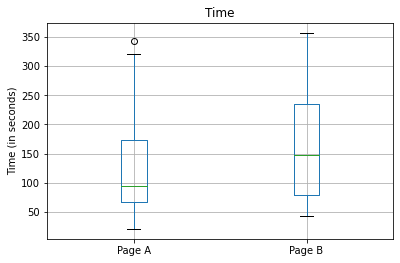

In [6]:
ax = session_times.boxplot(by="Page", column="Time")
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

In [12]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

35.66666666666667

Page B has session time greater than Page A by 35.67 seconds on average. But the question is whether this difference is within the range of what random chancne might produce i.e. statistically insignificant.  
Let's apply permutation test - combine all sessions times together and then repeatedly shuffle and divide them into groups of 21 (as ${n_A}=21$) and 15 (as ${n_B}=15$)

In [4]:
def permute(x, na, nb):
    n = na+nb
    idx_B = set(random.sample(range(n), nb)) #Sampling without replacement
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [ ]:

na = session_times[session_times.Page=="Page A"].shape[0]
nb = session_times[session_times.Page=="Page B"].shape[0]

print(permute(session_times.Time, na, nb))

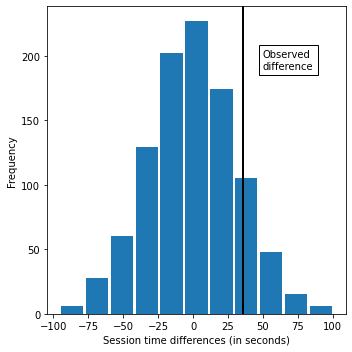

In [33]:
random.seed(1)
perm_diffs = [ permute(session_times.Time, na, nb) for _ in range(1000) ]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
print(np.mean(np.array(perm_diffs) > (mean_b - mean_a)))

0.121


So mean difference of random permutations often exceeds the observed difference in session times (vertical line). For our result, this happens in 12.1% of the cases.  
Thus suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.  

### Statistical Significance and P-Values

Observed difference: 0.0368%


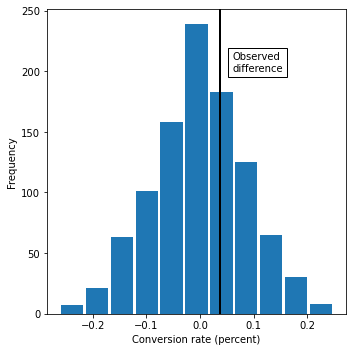

In [5]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * permute(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### P value

In [6]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [13]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


#### T test

In [18]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                     session_times[session_times.Page == 'Page B'].Time, equal_var=False)

print(f"p value for single sided test {res.pvalue/2 : .4f}")

p value for single sided test  0.1408


In [21]:
tstat, pvalue, df = sm.stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
                                      usevar='unequal', alternative='smaller')
print(f"p value for single sided test {pvalue : .4f}")

p value for single sided test  0.1408


Alternative hypothesis is that the session time mean for page A is less than that for page B.  

#### ANOVA

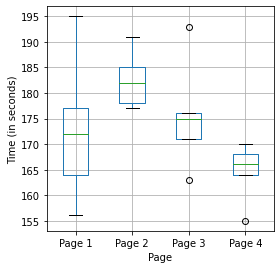

In [23]:
four_sessions = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/four_sessions.csv")

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [25]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
61.18666666666678


Pr(Prob) 0.07866666666666666


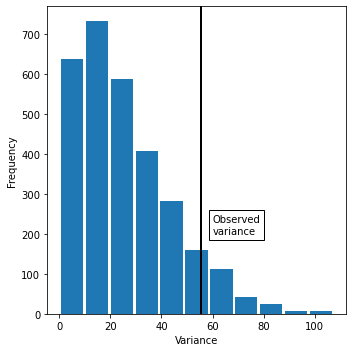

In [26]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### F Statistic

In [29]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
aov_table  = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [30]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


##### Two-way anova only available with statsmodels  

```python
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = smf.ols(formula, four_sessions).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)
```

#### Chi Square test  
##### Resampling approach

In [2]:
# Table 3-4
click_rate = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/click_rates.csv")
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [3]:
click_rate.head(2)

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986


In [4]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [5]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4690


In [6]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


##### Figure chi-sq distribution

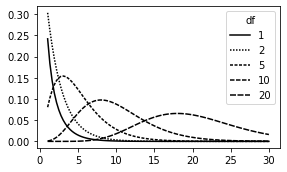

In [7]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

#### Fisher's Exact Test
Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler.

```Python
stats.fisher_exact(clicks)
```

#### Scientific Fraud

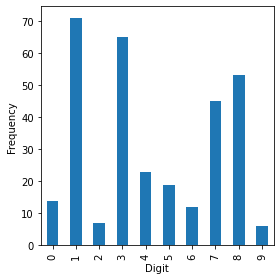

In [10]:
imanishi = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/imanishi_data.csv")
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [11]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [12]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
